# 👮 Weak supervision rules for text classification with semantic search

In this tutorial, we show how weak supervision workflows in Argilla can be extended with sentence embeddings.
We start from the weak supervision workflow presented in our [Weak supervision with Argilla tutorial](/tutorials/techniques/weak_supervision.html) and improve on its results by extending the coverage of its rules.

- ✍️ We define rules and generate weak labels for the [ag_news](https://huggingface.co/datasets/ag_news) data set.
- 🧱 We extend our weak labels with sentence embeddings from the [Sentence Transformers](https://www.sbert.net/) library.
- 📰 Finally, we use a label model to generate data for training a downstream model as a news classifier.
- 🚀 We achieve a **4% improvement** in accuracy over the original workflow simply by extending our weak labels.

![Original and extended coverage of the weak labels](/_static/tutorials/labelling-textclassification-sentencetransformers-weaksupervision/labelling-textclassification-sentencetransformers-weaksupervision.png)

The two plots above show the coverage of the weak labels before and after extending them with embeddings. Each point corresponds to an example in the ag news test set. The color indicates the corresponding class of the example. Points in a transparent circle are covered by at least one rule. 

## Introduction

Labeling functions normally have high precision, but low coverage. Only records that strictly match the conditions determined by a given function will be labelled, while other potential candidates will be left out. 

Building on [the findings of the Hazy Research group](https://github.com/HazyResearch/epoxy), we present a way to solve this problem by extending the weak labels produced by our labeling functions with sentence embeddings. 

We extend the coverage of our labeling functions by giving unlabelled records the same label as their nearest labelled neighbor in the embedding space if the cosine similarity between them scores above a certain threshold.    

We will show in this tutorial that, by adjusting these similarity thresholds and selecting proper sentence embeddings, we are able to significantly improve the accuracy of the downstream classifiers produced by our weak supervision workflows.

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:


**Deploy Argilla on Hugging Face Spaces**: If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/new-space?template=argilla/argilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).


**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](/getting_started/quickstart_installation.html). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter Notebook tool of your choice.
</div>

## Setup 

For this tutorial, you'll need to install the Argilla client and a few third-party libraries using `pip`:

In [ ]:
%pip install argilla faiss-cpu sentence_transformers transformers datasets snorkel -qqq

Let's import the Argilla module for reading and writing data:

In [4]:
import argilla as rg

If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [5]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
# Replace workspace with the name of your workspace
rg.init(
    api_url="http://localhost:6900", 
    api_key="owner.apikey",
    workspace="admin"
)

If you're running a private Hugging Face Space, you will also need to set the [HF_TOKEN](https://huggingface.co/settings/tokens) as follows:

In [ ]:
# # Set the HF_TOKEN environment variable
# import os
# os.environ['HF_TOKEN'] = "your-hf-token"

# # Replace api_url with the url to your HF Spaces URL
# # Replace api_key if you configured a custom API key
# # Replace workspace with the name of your workspace
# rg.init(
#     api_url="https://[your-owner-name]-[your_space_name].hf.space", 
#     api_key="owner.apikey",
#     workspace="admin",
#     extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"},
# )

Now let's add the imports we need:

In [16]:
from datasets import load_dataset
from argilla.labeling.text_classification import Rule, add_rules, WeakLabels, Snorkel
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running
    tutorial_running()
except ImportError:
    print("Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry.")

## Detailed Workflow

A typical workflow to perform weak supervision with sentence embeddings is:

1. Create an Argilla dataset with your raw dataset. If you have some labelled data, you can log it into the same dataset.

2. Define a set of weak labeling rules with the Rules definition mode in the UI.

3. Create a `WeakLabels` object and apply the rules. You can load the rules from your dataset and add additional rules and labeling functions using Python. Typically, you’ll iterate between this step and step 2.

4. Extend the `WeakLabels` object by giving sentence embeddings for each record ( the rows of the matrix ) and a similarity threshold for each rule ( the columns of the matrix ). 

5. Once you are satisfied with your extended weak labels, use the extended matrix of the `WeakLabels` instance with your library/method of choice to build a training set or even train a downstream text classification model. You can iterate between this step and step 4 to try several threshold and embedding possibilities until you achieve a satisfactory result.

This guide shows you an end-to-end example using Snorkel. You could alternatively use any other label model available in Argilla. If you are interested in learning about other options, please check our [weak supervision guide](/tutorials/techniques/weak_supervision.html).

## The dataset

We will use the [ag_news](https://huggingface.co/datasets/ag_news) dataset, a well-known benchmark text classification model.

However, to guarantee a fair comparison, we will optimize the thresholds on a validation split, and leave the test split for the final evaluation.

In [17]:
agnews = load_dataset("ag_news")

agnews_train, agnews_valid = (
    agnews["train"].train_test_split(test_size=4000, seed=43).values()
)

  0%|          | 0/2 [00:00<?, ?it/s]

## 1. Create an Argilla dataset with unlabelled data and test data

Let’s load a labelled and unlabelled set of records into Argilla.

In [18]:
# Build our labelled records to evaluate our heuristic rules and optimize the thresholds
records = [
    rg.TextClassificationRecord(
        text=record["text"],
        metadata={"split": "labelled"},
        annotation=agnews_valid.features["label"].int2str(record["label"]),
        id=f"valid_{idx}",
    )
    for idx, record in enumerate(agnews_valid)
]

# Build our unlabelled records
records += [
    rg.TextClassificationRecord(
        text=record["text"],
        metadata={"split": "unlabelled"},
        id=f"train_{idx}",
    )
    for idx, record in enumerate(agnews_train.select(range(8000)))
]

# Log the records to Argilla
rg.log(records, name="agnews")

  0%|          | 0/12000 [00:00<?, ?it/s]

12000 records logged to https://dvilasuero-argilla-space-52456aa.hf.space/datasets/team/agnews


BulkResponse(dataset='agnews', processed=12000, failed=0)

After this step, you have a fully browsable dataset available that you can access via the [Argilla web app](/reference/webapp/index.html).

## 2. Defining rules

We will use the following rules.

In [19]:
# Define queries and patterns for each category (using ES DSL)
queries = [
    (["money", "financ*", "dollar*"], "Business"),
    (["war", "gov*", "minister*", "conflict"], "World"),
    (["footbal*", "sport*", "game", "play*"], "Sports"),
    (["sci*", "techno*", "computer*", "software", "web"], "Sci/Tech"),
]

# Define rules
rules = [Rule(query=term, label=label) for terms, label in queries for term in terms]

Now we can add them to the dataset as follows:

In [20]:
add_rules(dataset="agnews", rules=rules)

## 3. Building and analyzing weak labels

After building weak labels from our rules, their summary reveals the following:

In [21]:
# Apply the rules to the dataset to obtain the weak labels
weak_labels = WeakLabels(dataset="agnews")
weak_labels.summary()

Preparing rules:   0%|          | 0/16 [00:00<?, ?it/s]

Applying rules:   0%|          | 0/12000 [00:00<?, ?it/s]

,label,coverage,annotated_coverage,overlaps,conflicts,correct,incorrect,precision
money,{Business},0.008000,0.00925,0.002750,0.002083,13,24,0.351351
financ*,{Business},0.020667,0.02100,0.005417,0.004667,56,28,0.666667
dollar*,{Business},0.016250,0.01550,0.003833,0.002750,42,20,0.677419
war,{World},0.013750,0.01175,0.003000,0.001333,34,13,0.723404
gov*,{World},0.045167,0.04000,0.011083,0.006000,76,84,0.475000
minister*,{World},0.028917,0.03175,0.007167,0.002583,114,13,0.897638
conflict,{World},0.003167,0.00300,0.001333,0.000250,10,2,0.833333
footbal*,{Sports},0.014333,0.01475,0.005583,0.000333,53,6,0.898305
sport*,{Sports},0.020750,0.02375,0.006250,0.001333,87,8,0.915789
game,{Sports},0.039917,0.04150,0.013417,0.001917,132,34,0.795181


In the next steps, we will try to extend our weak labels matrix through sentence embeddings. 
In this way, we will increase the coverage of our rules, while maintaining an acceptable precision.

## 4. Using the weak labels

### Label model with Snorkel

Snorkel’s label model is by far the most popular option for using weak supervision, and Argilla provides built-in support for it. Here we fit our weak labels to the Snorkel label model, and then we check the performance on the records that have been covered by the rules.

In [22]:
# Create the Snorkel label model
label_model = Snorkel(weak_labels)

# Fit the model, for the learning rate and epochs we ran a quick grid search
label_model.fit(lr=0.002, n_epochs=10, progress_bar=False)

# Evaluate the label model
print(label_model.score(output_str=True))

              precision    recall  f1-score   support

      Sports       0.79      0.95      0.86       380
    Sci/Tech       0.80      0.76      0.78       454
       World       0.70      0.82      0.75       257
    Business       0.69      0.40      0.50       247

    accuracy                           0.76      1338
   macro avg       0.74      0.73      0.72      1338
weighted avg       0.76      0.76      0.75      1338



## 5. Extending the weak labels

Let's extend our weak labels and see how that impacts the evaluation of the Snorkel label model.


### Generate sentence embeddings

Let's generate sentence embeddings for each record of our weak labels matrix. Best results will be achieved through powerful general-purpose pre-trained embeddings, or by embeddings specifically pre-trained for the domain of the task at hand.  

Here we choose the `all-MiniLM-L6-v2` embeddings from the well-known [Sentence Transformers library](https://www.sbert.net/). Argilla allows us to experiment with embeddings from any source, as long as they are provided to the weak labels matrix as a two-dimensional array.

For instance, instead of Sentence Transformers, we could have used OpenAI [embeddings](https://beta.openai.com/docs/guides/embeddings/what-are-embeddings), or text embeddings from the [Tensorflow Hub](https://tfhub.dev/s?module-type=text-embedding). 

In [23]:
# Instantiate the model for the sentence embeddings
# We strongly recommend using a GPU for the computation of the embeddings
model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")

# Compute the embeddings and store them in a list
embeddings = []
for rec in tqdm(weak_labels.records()):
    embeddings.append(model.encode(rec.text))

  0%|          | 0/12000 [00:00<?, ?it/s]

### Set the thresholds

We start by making an educated guess on which thresholds will work for this particular weak label matrix. We set the thresholds for all rules to 0.60. This means that, for each rule, the label of a record will be extended to its nearest unlabelled neighbor if their cosine similarity is above this value. 

In [24]:
thresholds = [0.6] * len(rules)

### Extend the weak labels matrix

We call the `extend_matrix` method by providing the thresholds and the sentence embeddings.

In [25]:
weak_labels.extend_matrix(thresholds, embeddings)

  0%|          | 0/16 [00:00<?, ?it/s]

With the weak label matrix extended, we can check that coverage goes up.

In [26]:
weak_labels.summary()

,label,coverage,annotated_coverage,overlaps,conflicts,correct,incorrect,precision
money,{Business},0.017667,0.02025,0.009750,0.008083,43,38,0.530864
financ*,{Business},0.037500,0.03800,0.016417,0.013917,99,53,0.651316
dollar*,{Business},0.039667,0.04050,0.020583,0.017750,118,44,0.728395
war,{World},0.031833,0.03125,0.015083,0.008250,81,44,0.648000
gov*,{World},0.096083,0.08750,0.042000,0.024417,188,162,0.537143
minister*,{World},0.053750,0.05350,0.023000,0.008083,197,17,0.920561
conflict,{World},0.010583,0.00925,0.007833,0.003917,24,13,0.648649
footbal*,{Sports},0.018333,0.01925,0.007833,0.000333,71,6,0.922078
sport*,{Sports},0.036667,0.03900,0.014417,0.004000,142,14,0.910256
game,{Sports},0.062417,0.06525,0.026750,0.004917,211,50,0.808429


We also see that the average precision of our rules went down (from 0.75 to 0.66).
This drop, however, can be partially compensated by our label model.
If we fit our weak labels to a Snorkel label model again, we can see that the support went up significantly, as expected, while the drop in accuracy is minor.

In [27]:
label_model = Snorkel(weak_labels)
label_model.fit(lr=0.002, n_epochs=10, progress_bar=False)
print(label_model.score(output_str=True))

              precision    recall  f1-score   support

      Sports       0.81      0.95      0.87       550
    Sci/Tech       0.77      0.78      0.77       655
       World       0.70      0.84      0.76       468
    Business       0.72      0.38      0.50       428

    accuracy                           0.76      2101
   macro avg       0.75      0.74      0.73      2101
weighted avg       0.75      0.76      0.74      2101



You can have a look at the [Appendix](#Appendix:-Visualize-changes) for a detailed explanation of how the weak label matrix is extended under the hood.

Instead of using generic fixed thresholds, we recommend optimizing them in some way to get the highest performance gains.
Our optimization described in detail in the [Appendix](#Appendix:-Optimizing-the-thresholds) yielded the following thresholds:

In [28]:
optimized_thresholds = [
    0.4,
    0.4,
    0.6,
    0.4,
    0.5,
    0.8,
    1.0,
    0.4,
    0.4,
    0.5,
    0.6,
    0.4,
    0.4,
    0.6,
    0.6,
    0.8,
]


Each call to `extend_matrix` with thresholds and embeddings will build a [faiss](https://github.com/facebookresearch/faiss) index that will be cached inside the weak labels object. 

If we do not provide embeddings in our next calls to `extend_matrix`, this index will be reutilized, and a new extended matrix will replace the current extended matrix.
So extending the matrix with a new threshold is very cheap.

In [29]:
weak_labels.extend_matrix(optimized_thresholds)
label_model = Snorkel(weak_labels)
label_model.fit(lr=0.002, n_epochs=10, progress_bar=False)
print(label_model.score(output_str=True))

              precision    recall  f1-score   support

      Sports       0.87      0.90      0.88       883
    Sci/Tech       0.69      0.72      0.70       880
       World       0.78      0.74      0.76       751
    Business       0.64      0.62      0.63       826

    accuracy                           0.75      3340
   macro avg       0.74      0.74      0.74      3340
weighted avg       0.75      0.75      0.75      3340



The optimized thresholds seem to further reduce the accuracy of the label model but also increase the coverage significantly.

## 6. Training a downstream model

Now we will train the same downstream model as in the [previous tutorial](/tutorials/techniques/weak_supervision.html) but on the data produced by a label model from our extended weak labels.

Let us first define a helper function that is basically a copy & paste from the previous tutorial.

In [30]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics


def train_and_evaluate_downstream_model(label_model):
    """
    Train a downstream model with the predictions of a label model and
    evaluate it with the test split of the ag news dataset
    """
    # Get records with the predictions from the label model
    records = label_model.predict()

    # Turn str labels into integers
    label2int = label_model.weak_labels.label2int

    # Extract the training data
    X_train = [rec.text for rec in records]
    y_train = [label2int[rec.prediction[0][0]] for rec in records]

    # Define our final classifier
    classifier = Pipeline([("vect", CountVectorizer()), ("clf", MultinomialNB())])

    # Fit the classifier
    classifier.fit(
        X=X_train,
        y=y_train,
    )

    # Extract text and labels
    X_test = [rec["text"] for rec in agnews["test"]]
    y_test = [
        label2int[agnews["test"].features["label"].int2str(rec["label"])]
        for rec in agnews["test"]
    ]

    # Get predictions for the test set
    predicted = classifier.predict(X_test)

    return metrics.classification_report(
        y_test, predicted, target_names=[k for k in label2int.keys() if k]
    )


Now let's see how our downstream model compares with the original model from the [previous tutorial](/tutorials/techniques/weak_supervision.html).
Remember we achieved an accuracy of around **82%**.

In [31]:
print(train_and_evaluate_downstream_model(label_model))


              precision    recall  f1-score   support

      Sports       0.88      0.96      0.92      1900
    Sci/Tech       0.77      0.82      0.79      1900
       World       0.86      0.84      0.85      1900
    Business       0.82      0.71      0.76      1900

    accuracy                           0.83      7600
   macro avg       0.83      0.83      0.83      7600
weighted avg       0.83      0.83      0.83      7600



Now, with our extended weak label matrix, we were able to achieve an accuracy of **86%**, a 4% improvement over our original approach.

## Summary

In this tutorial you have seen how to improve your weak supervision workflows in Argilla using word embeddings. With very small changes to the original workflow, we were able to significantly increase the accuracy of our downstream models. This shows that Argilla can greatly reduce the amount of effort that human annotators need to put into writing rules before they can achieve exceptional results.

## Appendix: Visualize changes

Let's visualize how the weak labels matrix is being extended in a single row.

In [32]:
import pandas as pd


def get_transitions(weak_labels, idx):
    transitions = list(
        list(zip(row[0], row[1]))
        for row in zip(weak_labels._matrix, weak_labels._extended_matrix)
    )
    transitions = transitions[idx]
    label_dict = weak_labels.int2label
    rule_labels = weak_labels.summary().reset_index()["index"].values.tolist()[:-1]
    transitions_df = []
    for rule_idx, rule in enumerate(rule_labels):
        old_label = transitions[rule_idx][0]
        new_label = transitions[rule_idx][1]
        transitions_df.append(
            {
                "rule": rule,
                "old label": label_dict[old_label],
                "new label": label_dict[new_label],
            }
        )
    transitions_df = pd.DataFrame(transitions_df)
    text = weak_labels.records()[idx].text
    return transitions_df, text


transitions, text = get_transitions(weak_labels, 15)


By reading the selected record, we can clearly notice that it is a news article about world politics, and therefore should be classified as `World`.

In [33]:
text

'Nicaragua tells US it will destroy its antiaircraft missiles  MANAGUA, Nicaragua -- President Enrique Bolanos told US Defense Secretary Donald H. Rumsfeld yesterday that Nicaragua would completely eliminate a stockpile of hundreds of surface-to-air missiles with no expectation of compensation from the United States.'

Let's put side by side the row of the original weak labels matrix for this record ( the `"old label"` row ) and the same row after the extension ( the `"new label"` row ).     

We see that this news article was not labelled in the original matrix by any of our rules. 

However, it was the nearest unlabelled neighbor of two `Business` articles, matched by the rules `financ*` and `dollar*`, and its similarity with them scored above our selected thresholds. The same happened for two `World` articles, matched by the rules `war` and `minister*`, and for a `Sci/Tech` article matched by the rule `sci*`.  

In [34]:
transitions.transpose()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
rule,money,financ*,dollar*,war,gov*,minister*,conflict,footbal*,sport*,game,play*,sci*,techno*,computer*,software,web
old label,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
new label,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


## Appendix: Optimizing the thresholds

Each call to `extend_matrix` with thresholds and embeddings will build a [faiss](https://github.com/facebookresearch/faiss) index that will be cached inside the weak labels object. 

If we do not provide embeddings in our next calls to `extend_matrix`, this index will be reutilized, and a new extended matrix will replace the current extended matrix. This new matrix is an extension of the original weak labels matrix made according to our new similarity thresholds.

In [35]:
# Let's try to set all thresholds to 0.8 instead of 0.6.
thresholds = [0.8] * len(rules)

# As we have already generated the index in our first call, we just need to provide the thresholds.
weak_labels.extend_matrix(thresholds)


There are a few different approaches to find the best similarity thresholds for extending a weak labels matrix: we will list them from the least to the most computationally expensive.

### 1. Block the extension of low-overlap rules

After setting all similarity thresholds to a reasonable value, a good way to optimize the similarity thresholds on an individual level is to block the extension of rules with low overlap, as they are more likely to produce inaccurate results after extension.

In [36]:
summary = weak_labels.summary(normalize_by_coverage=True).reset_index().head(len(rules))
summary = summary.rename(columns={"index": "rule"})
summary = summary.sort_values(by="overlaps", ascending=True)[["rule", "overlaps"]]
summary = summary.reset_index()
summary


,index,rule,overlaps
0,11,sci*,0.158974
1,3,war,0.208092
2,2,dollar*,0.235577
3,4,gov*,0.236427
4,15,web,0.240664
5,5,minister*,0.244382
6,1,financ*,0.257692
7,8,sport*,0.287823
8,12,techno*,0.295580
9,10,play*,0.299259


In [37]:
thresholds = [0.6] * len(rules)

# Let's block the extension of the top 5 rules with the least overlap.
turn_off_index = summary["index"][0:6]

# We block the extension of a rule by setting its similarity threshold to 1.0.
for rule_index in turn_off_index:
    thresholds[rule_index] = 1.0

weak_labels.extend_matrix(thresholds)
label_model = Snorkel(weak_labels)
label_model.fit(lr=0.002, n_epochs=10, progress_bar=False)
print(train_and_evaluate_downstream_model(label_model))


              precision    recall  f1-score   support

      Sports       0.79      0.99      0.88      1900
    Sci/Tech       0.60      0.83      0.70      1900
       World       0.81      0.84      0.82      1900
    Business       0.91      0.31      0.46      1900

    accuracy                           0.74      7600
   macro avg       0.78      0.74      0.72      7600
weighted avg       0.78      0.74      0.72      7600



### 2. Brute force: Grid search over the label model

In this approach, we set all thresholds to an initial value, and then grid search for the best value for each one of them individually. Then we optimize for the harmonic mean between the coverage and the accuracy of the label model on the development set. This will ensure that we choose the thresholds with the best trade-off between both metrics.

We arrive at the same improvement as the previous approach, with a final accuracy of 86% over the test set.

In [38]:
def train_eval_labelmodel(ths):
    weak_labels.extend_matrix(ths)

    label_model = Snorkel(weak_labels)
    label_model.fit(lr=0.002, n_epochs=10, progress_bar=False)

    metrics = label_model.score()
    acc, sup, n = (
        metrics["accuracy"],
        metrics["macro avg"]["support"],
        len(weak_labels.annotation()),
    )
    coverage = sup / n
    return 2 * acc * coverage / (acc + coverage)


In [39]:
import copy
from tqdm.auto import tqdm
import numpy as np 

ths_range = np.arange(1, 0.3, -0.1)
n_ths = len(weak_labels.rules)

best_thresholds = [1.0] * n_ths
best_acc = 0.0
for i in tqdm(range(n_ths), total=n_ths):
    thresholds = best_thresholds.copy()
    for threshold in ths_range:
        thresholds[i] = threshold
        acc = train_eval_labelmodel(thresholds)
        if acc > best_acc:
            best_acc = acc
            best_thresholds = thresholds.copy()


  0%|          | 0/16 [00:00<?, ?it/s]

In [40]:
np.array(best_thresholds)


array([0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 1. , 0.4, 0.4, 0.4, 0.5, 0.4, 0.4,
       0.4, 0.5, 0.4])

In [41]:
weak_labels.extend_matrix(best_thresholds)
label_model = Snorkel(weak_labels)
label_model.fit(lr=0.002, n_epochs=10, progress_bar=False)
print(train_and_evaluate_downstream_model(label_model))


              precision    recall  f1-score   support

      Sports       0.89      0.97      0.93      1900
    Sci/Tech       0.62      0.88      0.73      1900
       World       0.79      0.88      0.83      1900
    Business       0.90      0.33      0.48      1900

    accuracy                           0.77      7600
   macro avg       0.80      0.77      0.74      7600
weighted avg       0.80      0.77      0.74      7600



### 3. Brute force: Grid search over the downstream model

Here again, we set all thresholds to an initial value and grid search for the best value for each individual threshold, but now we optimize for the accuracy of the downstream model on the development set. We arrive at a final accuracy of 85% on the test set, which is slightly less than what we achieved through the previous approaches.

In [42]:
# Retrieve records with annotations
test_ds = weak_labels.records(has_annotation=True)

# Extract text and labels
X_test_for_grid_search = [rec.text for rec in test_ds]
y_test_for_grid_search = [weak_labels.label2int[rec.annotation] for rec in test_ds]


def train_eval_downstream(ths):
    weak_labels.extend_matrix(ths)

    label_model = Snorkel(weak_labels)
    label_model.fit(lr=0.002, n_epochs=10, progress_bar=False)

    records = label_model.predict()

    X_train = [rec.text for rec in records]
    y_train = [weak_labels.label2int[rec.prediction[0][0]] for rec in records]

    classifier = Pipeline([("vect", CountVectorizer()), ("clf", MultinomialNB())])

    classifier.fit(
        X=X_train,
        y=y_train,
    )

    accuracy = classifier.score(
        X=X_test_for_grid_search,
        y=y_test_for_grid_search,
    )

    return accuracy


In [43]:
from copy import copy
from tqdm.auto import tqdm

best_thresholds, best_acc = [1.0] * len(weak_labels.rules), 0
ths_range = np.arange(1, 0.3, -0.1)
n_ths = len(weak_labels.rules)

for i in tqdm(range(n_ths), total=n_ths):
    thresholds = best_thresholds.copy()
    for threshold in ths_range:
        thresholds[i] = threshold
        acc = train_eval_downstream(thresholds)
        if acc > best_acc:
            best_acc = acc
            best_thresholds = thresholds.copy()


  0%|          | 0/16 [00:00<?, ?it/s]

In [44]:
np.array(best_thresholds)


array([0.4, 0.6, 0.6, 0.5, 1. , 0.6, 0.6, 0.5, 0.5, 0.5, 1. , 0.4, 1. ,
       0.7, 1. , 0.9])

In [45]:
weak_labels.extend_matrix(best_thresholds)
label_model = Snorkel(weak_labels)
label_model.fit(lr=0.002, n_epochs=10, progress_bar=False)
print(train_and_evaluate_downstream_model(label_model))


              precision    recall  f1-score   support

      Sports       0.86      0.97      0.91      1900
    Sci/Tech       0.79      0.77      0.78      1900
       World       0.88      0.82      0.85      1900
    Business       0.77      0.75      0.76      1900

    accuracy                           0.83      7600
   macro avg       0.82      0.83      0.82      7600
weighted avg       0.82      0.83      0.82      7600



### Tips on threshold optimization

Grid search with large downstream models, such as transformers, can be very expensive. In this scenario, we can consider to optimize only a subset of the thresholds or to optimize all thresholds on a small sample of the development set.    

Although in this tutorial we perform grid search sequentially, there is no impediment to speed it up by performing it in parallel, as long as we make deep copies of the weak labels object for each process or thread.

## Appendix: Plot extension



In [56]:
%pip uninstall umap 
%pip install umap-learn

Found existing installation: umap 0.1.1
Uninstalling umap-0.1.1:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/umap-0.1.1.dist-info/*
    /usr/local/lib/python3.8/dist-packages/umap/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.8/dist-packages/umap/__pycache__/layouts.rdist-30.py38.1.nbc
    /usr/local/lib/python3.8/dist-packages/umap/__pycache__/layouts.rdist-30.py38.nbi
    /usr/local/lib/python3.8/dist-packages/umap/aligned_umap.py
    /usr/local/lib/python3.8/dist-packages/umap/distances.py
    /usr/local/lib/python3.8/dist-packages/umap/layouts.py
    /usr/local/lib/python3.8/dist-packages/umap/parametric_umap.py
    /usr/local/lib/python3.8/dist-packages/umap/plot.py
    /usr/local/lib/python3.8/dist-packages/umap/sparse.py
    /usr/local/lib/python3.8/dist-packages/umap/spectral.py
    /usr/local/lib/python3.8/dist-packages/umap/umap_.py
    /usr/local/lib/python3.8/dist-packages/umap/utils.py
    /usr/local/lib/python3.8/dist-packages/u

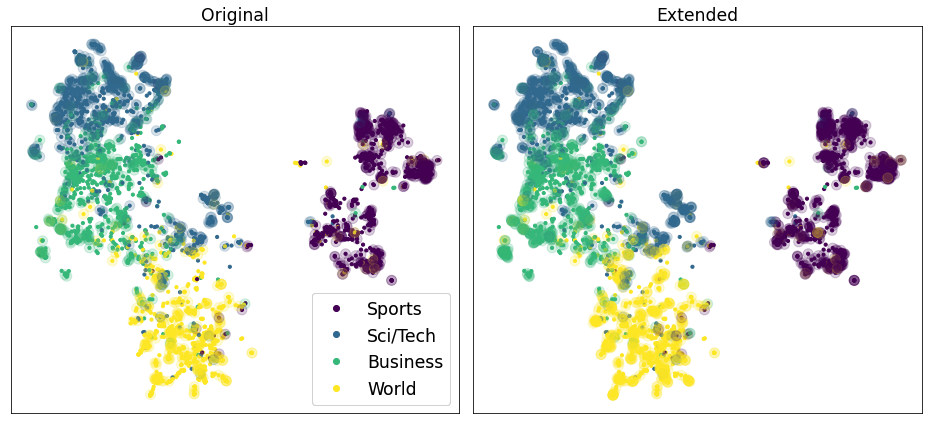

In [59]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

umap_data = umap.UMAP(
    n_neighbors=15, n_components=2, min_dist=0.0, metric="cosine"
).fit_transform(embeddings)

df = rg.DatasetForTextClassification(weak_labels.records()).to_pandas()
df["x"], df["y"] = umap_data[:, 0], umap_data[:, 1]
df["wl"] = [em for em in weak_labels._matrix]
df["wl_ext"] = [em for em in weak_labels._extended_matrix]

cov_idx = df["wl"].map(lambda x: x.sum() != -16)
cov_ext_idx = df["wl_ext"].map(lambda x: x.sum() != -16)
test_idx = ~(df.annotation.isna())

df_test = df[test_idx]
df_cov, df_cov_ext = df[cov_idx & test_idx], df[cov_ext_idx & test_idx]

label2int = {
    label: i for i, label in enumerate(df_test.annotation.value_counts().index)
}

fig, ax = plt.subplots(
    1,
    2,
    figsize=(13, 6),
)

ax[0].scatter(
    df_test.x, df_test.y, c=df_test.annotation.map(lambda x: label2int[x]), s=10
)
ax[0].scatter(
    df_cov.x,
    df_cov.y,
    c=df_cov.annotation.map(lambda x: label2int[x]),
    s=100,
    alpha=0.2,
)

scatter = ax[1].scatter(
    df_test.x, df_test.y, c=df_test.annotation.map(lambda x: label2int[x]), s=10
)
ax[1].scatter(
    df_cov_ext.x,
    df_cov_ext.y,
    c=df_cov_ext.annotation.map(lambda x: label2int[x]),
    s=100,
    alpha=0.2,
)

ax[0].set_title("Original", {"fontsize": "xx-large"})
ax[0].set_xticks([]), ax[0].set_yticks([])

ax[1].set_title("Extended", {"fontsize": "xx-large"})
ax[1].set_xticks([]), ax[1].set_yticks([])

labels = list(scatter.legend_elements())
labels[1] = list(label2int.keys())
legend1 = ax[0].legend(*labels, loc="lower right", fontsize="xx-large")
ax[0].add_artist(legend1)

fig.tight_layout()
plt.savefig("extend_weak_labels.png", facecolor="white", transparent=False)
